__Database__

Before reading this example, you should have read the examples:

 `overview/simple/fit.py`
 `overview/simple/result.py`

In the example `result.py`, we discussed the `Result`'s object, which contains information on the `NonLinearSearch`
samples, the best-fit model and parameter estimates and errors. If you are fitting a model to only one dataset, this
object suffices, but what if you are fitting the model to many datasets? How do you analyse, interpret and combine the
results?

Lets extend our example of fitting a 1D `Gaussian` profile and fit 3 independent datasets containing 1D Gaussians,
such that the results of every `NonLinearSearch` are in an ordered path structure on our hard-disk. we'll then use
the `Aggregator` to load the results of all 3 *non-linear searches*:

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autofit as af

from os import path
import numpy as np

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


__Model__

We create the same model used in the example `autofit_workspace/notebooks/overview/simple/fit.ipynb`.

In [2]:


class Gaussian:
    def __init__(
        self,
        centre=0.0,  # <- PyAutoFit recognises these constructor arguments
        intensity=0.1,  # <- are the Gaussian`s model parameters.
        sigma=0.01,
    ):
        """Represents a 1D `Gaussian` profile, which may be treated as a model-component of PyAutoFit the
        parameters of which are fitted for by a non-linear search.

        Parameters
        ----------
        centre : float
            The x coordinate of the profile centre.
        intensity : float
            Overall intensity normalisation of the `Gaussian` profile.
        sigma : float
            The sigma value controlling the size of the Gaussian.
        """

        self.centre = centre
        self.intensity = intensity
        self.sigma = sigma

    def profile_from_xvalues(self, xvalues):
        """
        Calculate the intensity of the profile on a line of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Gaussian, using its centre.

        Parameters
        ----------
        xvalues : np.ndarray
            The x coordinates in the original reference frame of the grid.
        """

        transformed_xvalues = xvalues - self.centre

        return np.multiply(
            np.divide(self.intensity, self.sigma * np.sqrt(2.0 * np.pi)),
            np.exp(-0.5 * np.square(np.divide(transformed_xvalues, self.sigma))),
        )


__Analysis__

We also create the same `Analysis` used in the example `autofit_workspace/notebooks/overview/simple/fit.ipynb`.

In [3]:


class Analysis(af.Analysis):
    def __init__(self, data, noise_map):

        super().__init__()

        self.data = data
        self.noise_map = noise_map

    def log_likelihood_function(self, instance):
        """
        Determine the log likelihood of a fit of a `Gaussian` to the dataset, using a model instance of the Gaussian.

        Parameters
        ----------
        instance : model.Gaussian
            The `Gaussian` model instance.

        Returnsn
        -------
        fit : Fit.log_likelihood
            The log likelihood value indicating how well this model fit the dataset.
        """

        xvalues = np.arange(self.data.shape[0])
        model_data = instance.profile_from_xvalues(xvalues=xvalues)
        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0
        log_likelihood = -0.5 * sum(chi_squared_map)

        return log_likelihood


For each dataset we are going to set up its output path, create its mask and fit it with the phase above. 

The 3 datasets will come from the `autofit_workspace/dataset/example_1d` folder.

We want our results to be in a folder specific to the dataset. we'll use the `Dataset`'s name string to do this. Lets
create a list of all 3 of our dataset names.

We'll also pass these names to the dataset when we create it, the name will be accessible to the aggregator, and we 
will use it to label  figures we make via the aggregator.

In [4]:
dataset_names = ["gaussian_x1_0", "gaussian_x1_1", "gaussian_x1_2"]

We can also attach information to the model-fit, by setting up an info dictionary. 

Information about our model-fit (e.g. the dataset) that isn't part of the model-fit is made accessible to the 
aggregator. For example, below we write info on the dataset`s data of observation and exposure time.

In [5]:
info = {"date_of_observation": "01-02-18", "exposure_time": 1000.0}

__Model__

Next, we create our model, which again corresponds to a single `Gaussian` and we'll manually specify its priors.

In [6]:
model = af.PriorModel(Gaussian)

model.centre = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.intensity = af.LogUniformPrior(lower_limit=1e-2, upper_limit=1e2)
model.sigma = af.GaussianPrior(
    mean=10.0, sigma=5.0, lower_limit=0.0, upper_limit=np.inf
)

This for loop runs over every dataset, checkout the comments below for how we set up the path structure.

In [7]:
for dataset_name in dataset_names:

    """The code below sets up the Analysis and creates the mask."""
    dataset_path = path.join("dataset", "example_1d", dataset_name)

    data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
    noise_map = af.util.numpy_array_from_json(
        file_path=path.join(dataset_path, "noise_map.json")
    )

    analysis = Analysis(data=data, noise_map=noise_map)

    """
    In all examples so far, our results have gone to the default path, which was the `/output/` folder and a folder
    named after the non linear search. 
    
    Below, using the `Paths` class and the input parameter `path_pefix`, we define the names of folders that the phase 
    goes in between the output path and phase paths as:

    `/path/to/autofit_workspace/output/aggregator_example/gaussian_x1_0`
    
    Note that this therefore means the fit to each dataset will go into a unique folder.
    """
    emcee = af.Emcee(
        paths=af.Paths(path_prefix=path.join("overview", "database", dataset_name)),
        nwalkers=30,
        nsteps=1000,
        initializer=af.InitializerBall(lower_limit=0.49, upper_limit=0.51),
        auto_correlation_check_for_convergence=True,
        auto_correlation_check_size=100,
        auto_correlation_required_length=50,
        auto_correlation_change_threshold=0.01,
        number_of_cores=1,
    )

    print(
        f"Emcee has begun running - checkout the autofit_workspace/output/{dataset_name} folder for live "
        f"output of the results. This Jupyter notebook cell with progress once Emcee has completed - this could take a "
        f"few minutes!"
    )

    result = emcee.fit(model=model, analysis=analysis)

print("Emcee has finished run - you may now continue the notebook.")

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No Emcee samples found, beginning new non-linear search.
  1%|          | 6/500 [00:00<00:09, 52.74it/s]

Emcee has begun running - checkout the autofit_workspace/output/gaussian_x1_0 folder for live output of the results. This Jupyter notebook cell with progress once Emcee has completed - this could take a few minutes!


100%|██████████| 500/500 [00:10<00:00, 49.90it/s]
INFO:root:500 Iterations: Performing update (Visualization, outputting samples, etc.).
100%|██████████| 500/500 [00:08<00:00, 57.10it/s]
INFO:root:1000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:Emcee sampling complete.
INFO:root:1500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No Emcee samples found, beginning new non-linear search.
  1%|▏         | 7/500 [00:00<00:08, 61.32it/s]

Emcee has begun running - checkout the autofit_workspace/output/gaussian_x1_1 folder for live output of the results. This Jupyter notebook cell with progress once Emcee has completed - this could take a few minutes!


100%|██████████| 500/500 [00:08<00:00, 58.09it/s]
INFO:root:500 Iterations: Performing update (Visualization, outputting samples, etc.).
100%|██████████| 500/500 [00:08<00:00, 57.42it/s]
INFO:root:1000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:Emcee sampling complete.
INFO:root:1500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No Emcee samples found, beginning new non-linear search.
  1%|▏         | 7/500 [00:00<00:08, 60.77it/s]

Emcee has begun running - checkout the autofit_workspace/output/gaussian_x1_2 folder for live output of the results. This Jupyter notebook cell with progress once Emcee has completed - this could take a few minutes!


100%|██████████| 500/500 [00:09<00:00, 51.02it/s]
INFO:root:500 Iterations: Performing update (Visualization, outputting samples, etc.).
100%|██████████| 500/500 [00:08<00:00, 56.28it/s]
INFO:root:1000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:Emcee sampling complete.
INFO:root:1500 Iterations: Performing update (Visualization, outputting samples, etc.).


Emcee has finished run - you may now continue the notebook.


Checkout the output folder, you should see three new sets of results corresponding to the 3 `Gaussian` datasets.
Unlike previous tutorials, these folders in the output folder are named after the dataset.

To load these results with the aggregator, we simply point it to the path of the results we want it to inspect.

In [8]:
agg = af.Aggregator(directory=path.join("output", "overview", "database"))

Aggregator loading phases... could take some time.

 A total of 3 phases and results were found.


To begin, let me quickly explain what a generator is in Python, for those unaware. A generator is an object that 
iterates over a function when it is called. The aggregator creates all objects as generators, rather than lists, or 
dictionaries, or whatever.

Why? Because lists and dictionaries store every entry in memory simultaneously. If you fit many datasets, you`ll have 
lots of results and therefore use a lot of memory. This will crash your laptop! On the other hand, a generator only 
stores the object in memory when it runs the function; it is free to overwrite it afterwards. Thus, your laptop won't 
crash!

There are two things to bare in mind with generators:

1) A generator has no length, thus to determine how many entries of data it corresponds to you first must turn it to a 
list.

2) Once we use a generator, we cannot use it again - we'll need to remake it. For this reason, we typically avoid 
   storing the generator as a variable and instead use the aggregator to create them on use.

We can now create a `samples` generator of every fit. An instance of the `Samples` class acts as an 
interface between the results of the non-linear fit on your hard-disk and Python and was discussed in the `results.py`
example.

In [9]:
samples_gen = agg.values("samples")

When we print this list of outputs you should see 3 different MCMCSamples instances, corresponding to the 3 model-fits
performed above.

In [10]:
print("Emcee Samples:\n")
print(samples_gen)
print("Total Samples Objects = ", len(list(samples_gen)), "\n")

Emcee Samples:

Total Samples Objects =  3 



The `Samples` class is described in the `result.py` example script. Using the `Aggregator` we can access all of the 
attributes described in that example, for example the value of every parameter.

Refer to `result.py` for all the properties that are accessible via the `Aggregator`.

In [11]:
for samples in agg.values("samples"):
    print("All parameters of the very first sample")
    print(samples.parameters[0])
    print("The tenth sample`s third parameter")
    print(samples.parameters[9][2], "\n")

All parameters of the very first sample
[51.21595513044038, 1.1209604255490795, 9.980171961153937]
The tenth sample`s third parameter
9.97820201322676 

All parameters of the very first sample
[49.707708138873876, 1.059637343506453, 9.914879350877028]
The tenth sample`s third parameter
10.00334585755955 

All parameters of the very first sample
[49.39537150569105, 1.1061110219826922, 9.814587627453525]
The tenth sample`s third parameter
10.041107289239848 



Using the `Aggregator`'s filter tool, we can remove certain fits and load only the fits we are interested in. We filter
for results by inputting a string (or strings) that the output path of the results we are loading must contain.

For example, by inputting the string `gaussian_x1_1` the output path must contain this string, 
meaning we only load the results of the *model-fit* to the second `Gaussian` in our dataset:

In [12]:
agg_filter = agg.filter(agg.directory.contains("gaussian_x1_1"))
samples_gen = agg_filter.values("samples")

Filter found a total of 1 results


As expected, this list now has only 1 MCMCSamples corresponding to the second dataset.

In [13]:
print("Filtered Emcee Samples:\n")
print(samples_gen)
print("Total Samples Objects = ", len(list(samples_gen)), "\n")

Filtered Emcee Samples:

Total Samples Objects =  1 



Lets next try something more ambitious and create a plot of the inferred sigma values vs intensity of each
Gaussian profile, including error bars at 3 sigma confidence.

This will use many of the methods described in the `result.py` example scripts, so if anything below appears new or
unclear checkout that script for a explanation.

[<__main__.Gaussian object at 0x7f5cc6d921f0>, <__main__.Gaussian object at 0x7f5cc6f9bdf0>, <__main__.Gaussian object at 0x7f5cc703ca00>]


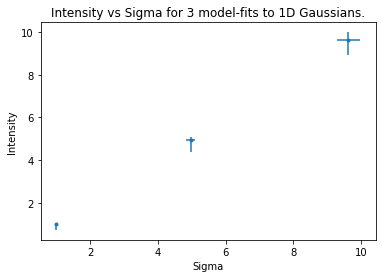

In [14]:
import matplotlib.pyplot as plt

mp_instances = [samps.median_pdf_instance for samps in agg.values("samples")]
ue3_instances = [
    out.error_instance_at_upper_sigma(sigma=3.0) for out in agg.values("samples")
]
le3_instances = [
    out.error_instance_at_lower_sigma(sigma=3.0) for out in agg.values("samples")
]

print(mp_instances)

mp_sigmas = [instance.sigma for instance in mp_instances]
ue3_sigmas = [instance.sigma for instance in ue3_instances]
le3_sigmas = [instance.sigma for instance in le3_instances]
mp_intensitys = [instance.sigma for instance in mp_instances]
ue3_intensitys = [instance.sigma for instance in ue3_instances]
le3_intensitys = [instance.intensity for instance in le3_instances]

plt.errorbar(
    x=mp_sigmas,
    y=mp_intensitys,
    marker=".",
    linestyle="",
    xerr=[le3_sigmas, ue3_sigmas],
    yerr=[le3_intensitys, ue3_intensitys],
)
plt.title("Intensity vs Sigma for 3 model-fits to 1D Gaussians.")
plt.ylabel("Intensity")
plt.xlabel("Sigma")
plt.show()

The Probability Density Functions (PDF's) of the results can be plotted using the library:

 corner.py: https://corner.readthedocs.io/en/latest/

(In built visualization for PDF's and non-linear searches is a future feature of PyAutoFit, but for now you`ll have to 
use the libraries yourself!).

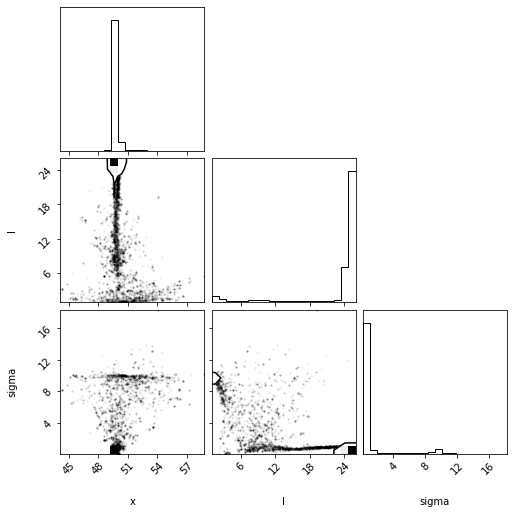

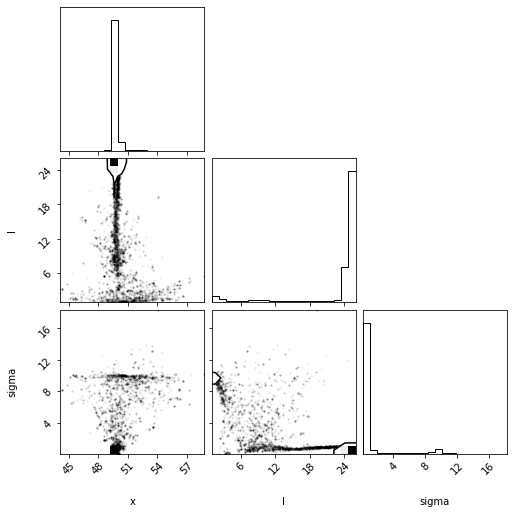

In [15]:
import corner

samples = list(agg.values("samples"))[0]

corner.corner(
    xs=samples.parameters,
    weights=samples.weights,
    labels=samples.model.parameter_labels,
)

Finish.